# Tuning and Validating Model Thresholds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'
jet_cmap = cm.get_cmap('Spectral')

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','ueo_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row

def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_mcc(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_MCC'] = matthews_corrcoef(row[col+'_bool'],ch_preds)
    return row

## Config

In [5]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Loading External Benchmark

In [6]:
alt_annots = pd.read_csv(ospj(metapath,'Results_Raw_FINAL.csv'))
alt_onset_annots_1k = alt_annots[(alt_annots['Cutoff Frequency'] == 1000) & (alt_annots['Symbol Number'] == str(1))]
grouped_annots = alt_onset_annots_1k.groupby(['Marker','Patient File']).apply(lambda x: [y['Channel Marked'] for _,y in x.iterrows()]).reset_index()
all_dice = []
for i_g, group in grouped_annots.groupby('Patient File'):
    if len(group) <= 1:
        continue
    dice_val = 0
    for i_annot in range(len(group)):
        for j_annot in range(i_annot+1,len(group)):
            dice_val += dice_score(np.atleast_1d(group.iloc[i_annot,2]),np.atleast_1d(group.iloc[j_annot,2]))
    dice_val /= (len(group)*(len(group)-1))/2
    all_dice.append(dice_val)
all_dice = np.atleast_1d(all_dice)

0.2788888888888889
0.15796024920598886


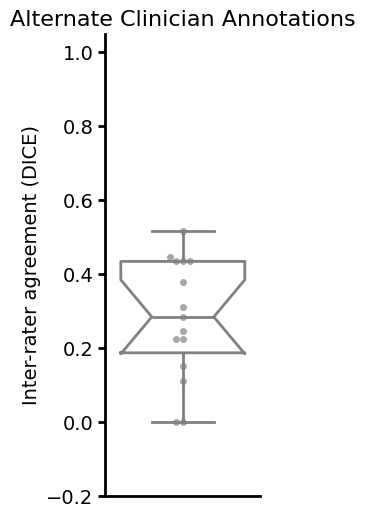

In [7]:
# all_dice = all_dice[all_dice > 0]
plt.figure(figsize=(2,6))
sns.boxplot(all_dice,color='gray',fill=False,notch=True)
sns.swarmplot(all_dice,color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
print(np.mean(all_dice))
print(np.std(all_dice))
sns.despine()
plt.title('Alternate Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);

In [8]:
external_annots = pd.DataFrame(np.hstack((all_dice.reshape(-1,1),np.array(["Ext. Clin."]*len(all_dice)).reshape(-1,1))),columns=["dice","model"])

## Formatting Model Predictions

### Channel level

In [9]:
# # Loading in human annotations with consensus annotation already created
# annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# # Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# # Sorting
# predicted_channels.sort_values('approximate_onset',inplace=True)
# # predicted_channels = predicted_channels[predicted_channels.stim == 0]
# annotations_df.sort_values('approximate_onset',inplace=True)

# # Creating a merged table with human and machine annotations based on approximate seizure onset time
# pred_channels_wannots = pd.merge_asof(predicted_channels,
#                                     annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
#                                     on='approximate_onset',by='Patient',
#                                     tolerance = 240,
#                                     direction='nearest')
# pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
# pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
# pred_channels_wmcc = pred_channels_wannots.apply(apply_mcc,axis=1)
# # pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# # # pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # # # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [10]:
# pred_channels_wmcc.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc.pkl"))
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
# pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))
# # pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### Calculating clinician consensus


In [11]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))

In [12]:
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
# Potentially put this back in for older version of results
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]

In [13]:
consensus_annots.head(1)

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.766309,Clin.,0.766309


In [14]:
individual_annot_score = consensus_annots.copy()
note_type = 'ueo'
row_list = []
for i_r, row in individual_annot_score.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2: 
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            row_list.append({
                'model': row.clinician[i_annot],
                'patient': row.patient,
                'approximate_onset': row.approximate_onset,
                'stim': row.stim,
                'MCC': matthews_corrcoef(annots[i_annot],annots[j_annot])
            })
            row_list.append({
                'model': row.clinician[j_annot],
                'patient': row.patient,
                'approximate_onset': row.approximate_onset,
                'stim': row.stim,
                'MCC': matthews_corrcoef(annots[i_annot],annots[j_annot])
            })
individual_annot_df = pd.DataFrame(row_list)

([<matplotlib.axis.XTick at 0x7f806e3cae90>,
 [Text(0, 0, 'Clin 1'),
  Text(1, 0, 'Clin 2'),
  Text(2, 0, 'Clin 3'),
  Text(3, 0, 'Clin 4'),
  Text(4, 0, 'Clin 5')])

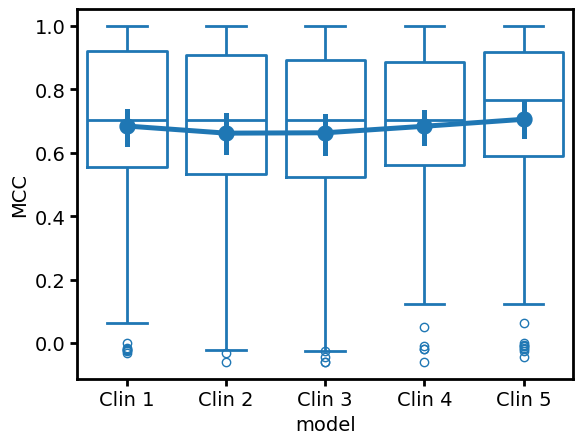

In [15]:
sns.boxplot(individual_annot_df,x='model',y='MCC',fill=False)
sns.pointplot(individual_annot_df,x='model',y='MCC')
plt.xticks(np.arange(5),['Clin ' + str(i+1) for i in range(5)])

In [16]:
x = consensus_annots[consensus_annots.patient == 'HUP238']
x['ueo_chs'] = x.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
x['sec_chs'] = x.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)
x

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,...,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice,ueo_chs,sec_chs
40,HUP238_1,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, True, False, False, False, False, Fal...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,10640.8600,10792.34,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",10653.04,"[False, True, False, False, False, False, Fals...","[False, True, False, False, False, False, Fals...",0.850877,Clin.,0.850877,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LB01, LB02, LC01, LC02, LC03, LI01]"
41,HUP238_2,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[290008.46, 290008.61, 290009.78, 290008.61, 2...","[[False, True, True, False, False, False, Fals...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,290006.9060,290152.56,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",290008.61,"[False, True, True, False, False, False, False...","[False, True, True, True, False, False, False,...",0.752348,Clin.,0.752348,"[LB01, LB02, LC01, LC02]","[LA01, LA02, LB01, LB02, LC01, LC02, LC03, LG0..."
42,HUP238_3,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[412269.46, 412269.46, 412269.46, 412269.29, 4...","[[False, False, False, False, False, False, Fa...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,412267.6988,412383.25,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",412269.46,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.820962,Clin.,0.820962,"[LC01, LC02]","[LB01, LB02, LC01, LC02, LG01, LG02, LI01]"
43,HUP238_4,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[465566.01, 465565.78, 465566.05, 465566.04, 4...","[[False, True, False, False, False, False, Fal...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,465564.6090,465680.72,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",465566.04,"[False, True, True, False, False, False, False...","[False, True, True, True, True, True, True, Tr...",0.880642,Clin.,0.880642,"[LC01, LC02]","[LA01, LA02, LB01, LB02, LB03, LC01, LC02, LC0..."


0.6253192346282614


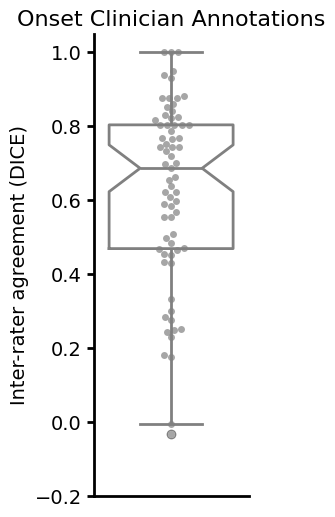

In [17]:
plt.figure(figsize=(2,6))
sns.boxplot(consensus_annots["dice"],color='gray',fill=False,notch=True)
sns.swarmplot(consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Onset Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
print(consensus_annots.dice.mean())

0.6159655003458416


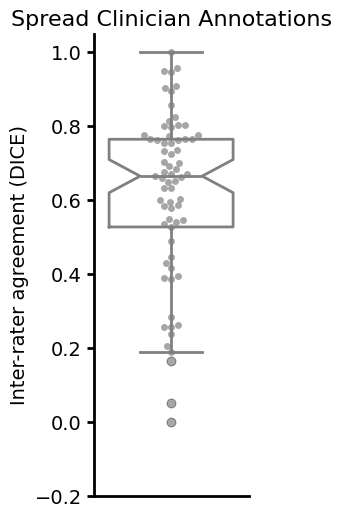

In [18]:
plt.figure(figsize=(2,6))
sns.boxplot(spread_consensus_annots["dice"],color='gray',fill=False,notch=True)
sns.swarmplot(spread_consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Spread Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
print(spread_consensus_annots.dice.mean())

In [19]:
sc.stats.mannwhitneyu(consensus_annots["dice"].dropna(),spread_consensus_annots["dice"].dropna())

MannwhitneyuResult(statistic=2503.5, pvalue=0.6019153433955593)

### Comparing annotators

In [20]:
sc.stats.mannwhitneyu(consensus_annots.dice.dropna(),all_dice)

MannwhitneyuResult(statistic=903.0, pvalue=6.898005099445701e-06)

### Data Prep

In [21]:
anntype='consensus'
mdl_anntype = 'loose'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wmcc.pkl"))
mdl_preds = mdl_preds[mdl_preds.model != 'NRG']

In [22]:
# mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [23]:
print(len(mdl_preds[mdl_preds.stim==1].approximate_onset.unique()))
print(mdl_preds.approximate_onset.nunique())
print(len(mdl_preds.Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].approximate_onset.unique()))

34
78
28
19
63


In [24]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [25]:
# melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_MCC',f'sec_chs_{mdl_anntype}_{anntype}_MCC']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
# mdl_preds_long.Patient.unique()

In [ ]:
# tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_loose_dice']
# val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_loose_dice']
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_chs_loose_consensus_MCC']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_chs_loose_consensus_MCC']

In [27]:
mdl_preds_long.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_chs_strict_bool', 'ueo_chs_strict_consensus_MCC',
       'ueo_chs_strict_any_MCC', 'ueo_chs_loose_bool', 'ueo_chs_loose_any_MCC',
       'sec_chs_strict_bool', 'sec_chs_strict_consensus_MCC',
       'sec_chs_strict_any_MCC', 'sec_chs_loose_bool', 'sec_chs_loose_any_MCC',
       'annot', 'dice'],
      dtype='object')

### Threshold sweeping

Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

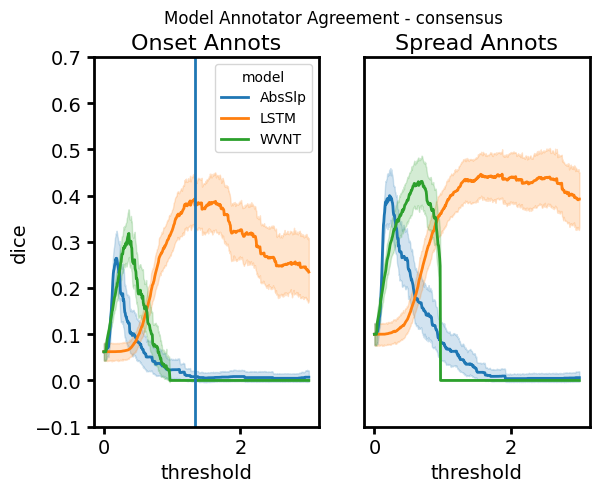

In [56]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((-.1,.7))
axs[0].set_title('Onset Annots')
axs[0].axvline(1.33)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_MCC'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.1,.7))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('Spread Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')
# fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

In [ ]:
from sklearn.model_selection import KFold
dict_list = []
for model in mdl_preds_sorted.model.unique():   
    # Assuming the DataFrame is named 'df' and already loaded
    df = mdl_preds_sorted[(mdl_preds_sorted['model'] == model) & (mdl_preds_sorted['stim'] == 0)]
    # Get unique patients
    unique_patients = df['Patient'].unique()

    # Create a KFold object to split patients
    kf = KFold(n_splits=len(unique_patients)-1, shuffle=False)

    optimal_thresholds = []
    cross_validated_mccs = []

    for fold, (train_index, test_index) in enumerate(kf.split(unique_patients), 1):
        train_patients = unique_patients[train_index]
        test_patients = unique_patients[test_index]

        # Create training and test DataFrames based on patient splits
        train_df = df[df['Patient'].isin(train_patients)]
        test_df = df[df['Patient'].isin(test_patients)]

        # Calculate average MCC for each threshold in the training set
        average_mcc_per_threshold = train_df.groupby('threshold')['ueo_chs_loose_consensus_MCC'].median()

        # Find the optimal threshold
        optimal_threshold = average_mcc_per_threshold.idxmax()
        optimal_thresholds.append(optimal_threshold)

        # Calculate MCC for each seizure in the test set at the optimal threshold
        test_seizures = test_df[test_df['threshold'] == optimal_threshold]
        for onset, seizure in test_seizures.groupby('approximate_onset'):
            cross_validated_mccs.extend(seizure['ueo_chs_loose_consensus_MCC'].values)
            dict_list.append({
                'patient': seizure.Patient.values[0],
                'approximate_onset': onset,
                'model': model,
                'stim': seizure.stim.values[0],
                'dice': seizure['ueo_chs_loose_consensus_MCC'].values[0],
                'threshold': optimal_threshold
            })

    # Calculate the population average threshold
    population_average_threshold = np.median(optimal_thresholds)

    # Calculate the cross-validated estimation of MCC
    cross_validated_mcc = np.median(cross_validated_mccs)

    print(f"Population average {model} threshold: {population_average_threshold,np.percentile(optimal_thresholds,[25,75])}")
    print(f"Cross-validated estimation of {model} MCC: {cross_validated_mcc}")
cval_preds = pd.DataFrame(dict_list)
cval_preds.loc[cval_preds.model == 'LSTM','model'] = 'NDD'
cval_preds.loc[cval_preds.model == 'WVNT','model'] = 'DL'

Population average AbsSlp threshold: (0.12625250501002003, array([0.12625251, 0.13827655]))
Cross-validated estimation of AbsSlp MCC: 0.07293540323345386
Population average LSTM threshold: (1.5390781563126252, array([1.53907816, 1.56913828]))
Cross-validated estimation of LSTM MCC: 0.4233548364806211
Population average WVNT threshold: (0.3366733466933868, array([0.31863727, 0.36072144]))
Cross-validated estimation of WVNT MCC: 0.3361037043653432


Text(31.763888888888886, 0.5, 'MCC')

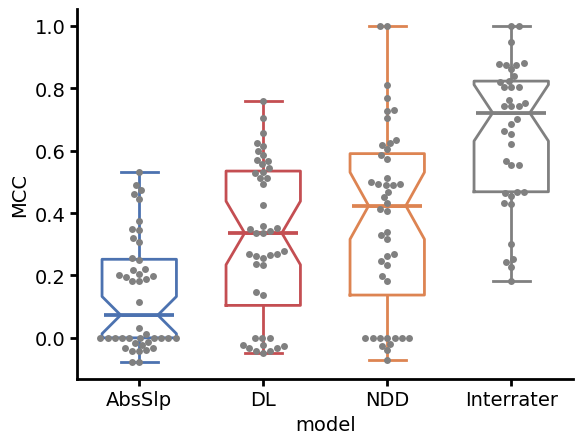

In [317]:
consensus_annots["model"] = ["Interrater"]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
consensus_annots = consensus_annots[consensus_annots.stim == 0]
cval_plot_agreements = pd.concat([cval_preds,consensus_annots[['patient',"model","dice","stim"]]]).dropna(subset='dice').reset_index(drop=True)
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
_,ax = plt.subplots()
sns.boxplot(cval_plot_agreements,x='model',y='dice',hue='model',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 hue_order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False,
                 ax=ax)
sns.swarmplot(cval_plot_agreements,x='model',y='dice',color='gray',ax=ax)
sns.pointplot(cval_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              hue_order = ['AbsSlp','DL','NDD','Interrater'],
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None,
              estimator='median',
              ax=ax)
sns.despine()
plt.ylabel('MCC')

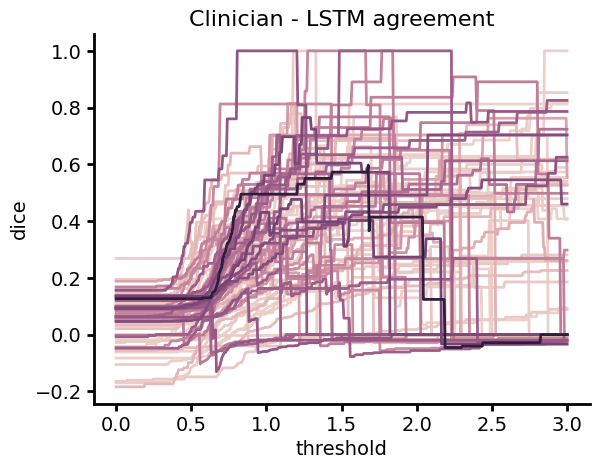

In [189]:
fig,ax = plt.subplots()
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],hue_order='Patient',x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')],hue_order='Patient',x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)

# plt.xlim([0,1])
plt.title('Clinician - LSTM agreement')
sns.despine()
fig.savefig(ospj(figpath,f'pt_LSTM_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

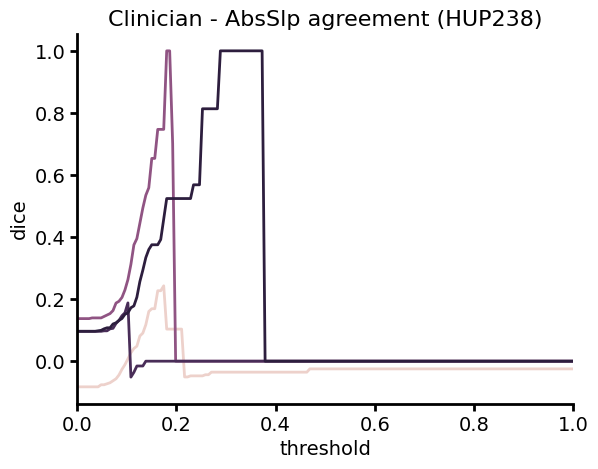

In [29]:
# ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'AbsSlp')& (mdl_preds_long.Patient == 'HUP238')],x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'AbsSlp')& (mdl_preds_long.Patient == 'HUP238')],x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
plt.xlim([0,1])
plt.title('Clinician - AbsSlp agreement (HUP238)')
sns.despine()


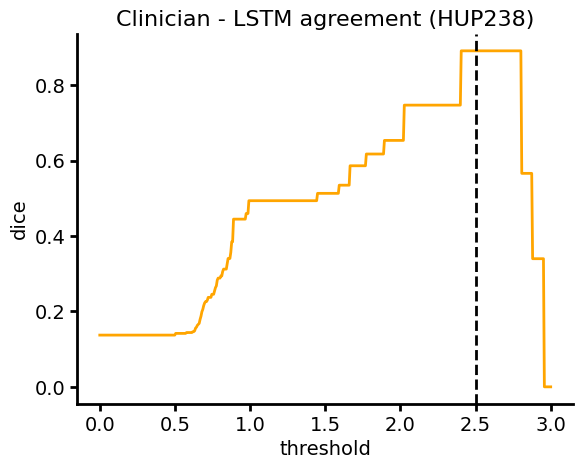

In [198]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_MCC') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')& (mdl_preds_long.approximate_onset == 290006.91)],x='threshold',y='dice',color='orange',errorbar=None,legend=False)
# plt.xlim([0,1])
plt.axvline(2.5,c='black',linestyle='--')
plt.title('Clinician - LSTM agreement (HUP238)')
sns.despine()

### Tuning at the seizure level

#### Tuning and testing on onset

In [216]:
tune_preds_long.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_chs_strict_bool', 'ueo_chs_strict_consensus_MCC',
       'ueo_chs_strict_any_MCC', 'ueo_chs_loose_bool', 'ueo_chs_loose_any_MCC',
       'sec_chs_strict_bool', 'sec_chs_strict_consensus_MCC',
       'sec_chs_strict_any_MCC', 'sec_chs_loose_bool', 'sec_chs_loose_any_MCC',
       'annot', 'dice'],
      dtype='object')

In [217]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]#,'ueo_chs_loose','ueo_consensus_chs']]

In [218]:
optimal_threshold_preds

,model,dice,Patient,stim,approximate_onset,threshold
99,AbsSlp,0.249459,CHOP005,1.0,68881.53,0.198397
1411,LSTM,0.226108,CHOP005,1.0,68881.53,2.825651
314,WVNT,0.241927,CHOP005,1.0,68881.53,0.625251
1644,AbsSlp,0.425922,CHOP024,1.0,87579.25,0.288577
2839,LSTM,0.526201,CHOP024,1.0,87579.25,2.681363
...,...,...,...,...,...,...
114754,LSTM,0.394591,HUP288,1.0,73007.74,1.509018
114305,WVNT,0.435286,HUP288,1.0,73007.74,0.607214
115566,AbsSlp,0.091449,HUP288,0.0,251098.53,0.132265
116188,LSTM,0.413585,HUP288,0.0,251098.53,1.376754


In [219]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice","stim"]]]).dropna(subset='dice')

In [220]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1.dropna(),optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=3774.0, pvalue=2.6473912841865775e-05)
LSTM
MannwhitneyuResult(statistic=3075.0, pvalue=0.13656801274818303)
WVNT
MannwhitneyuResult(statistic=3591.5, pvalue=0.0004766382026258424)


In [221]:
# all_plot_agreements = pd.concat([all_plot_agreements,external_annots])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

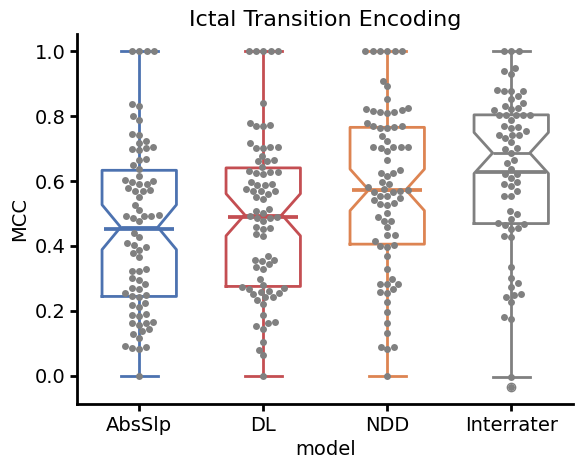

In [222]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],
                 width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',
              palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],
              marker='_',markersize=50,errorbar=None)
sns.despine()
plt.ylabel('MCC')
plt.title("Ictal Transition Encoding")
plt.savefig(ospj(figpath,'onset_tuned_onset_detection.pdf'))

In [223]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.median(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice']), np.mean(all_plot_agreements[all_plot_agreements.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[:2])

AbsSlp NDD
0.4568412636016248 0.5723953690279964
2213.0 0.0033143899481624006
NDD DL
0.5718342250782673 0.48958501331406695
3659.0 0.0288480812284787
NDD Interrater
0.5718342250782673 0.6253192346282613
2307.0 0.13656801274818303


(array([ True,  True]),
 array([0.00661779, 0.02884808]),
 0.025320565519103666,
 0.025)

In [224]:
all_plot_agreements = pd.concat([all_plot_agreements,external_annots])


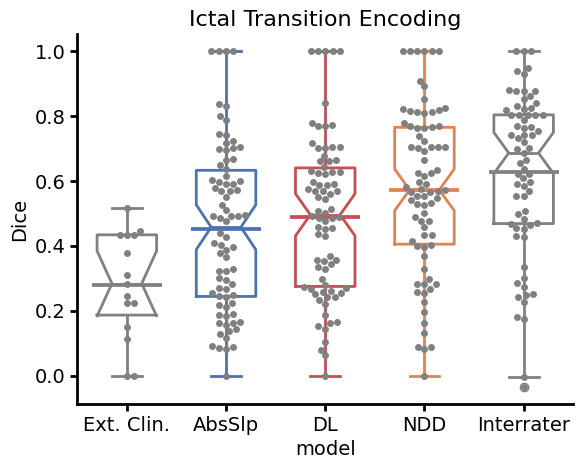

In [225]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([[.5,.5,.5],colors,[.5,.5,.5]]),
                 order=['Ext. Clin.','AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray',order=['Ext. Clin.','AbsSlp','DL','NDD','Interrater'])
g = sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([[.5,.5,.5],np.array(colors),[.5,.5,.5]]),
              order = ['Ext. Clin.','AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None)
sns.despine()
plt.ylabel('Dice')
plt.title("Ictal Transition Encoding")
g.invert_yaxis()

#### Testing on spread

In [226]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [42]:
val_tuned_thresholds = val_preds_long.loc[val_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold']]#,'ueo_chs_loose','ueo_consensus_chs']]

In [43]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [44]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

In [45]:
all_plot_agreements[all_plot_agreements.model == 'Interrater'].dice.mean()

0.6159655003458416

In [46]:
all_ps = []
for mdl in all_plot_agreements.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice)
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

AbsSlp
MannwhitneyuResult(statistic=nan, pvalue=nan)
NDD
MannwhitneyuResult(statistic=nan, pvalue=nan)
DL
MannwhitneyuResult(statistic=nan, pvalue=nan)
Interrater
MannwhitneyuResult(statistic=nan, pvalue=nan)


(array([ True,  True,  True,  True]),
 array([nan, nan, nan, nan]),
 0.012741455098566168,
 0.0125)

Text(0.5, 1.0, 'Ictal Activity Encoding')

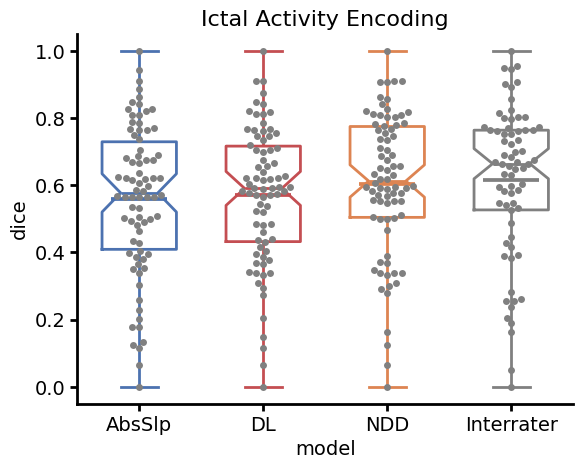

In [47]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'])
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=40,errorbar=None)
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False,whis=100)
sns.despine()
plt.title("Ictal Activity Encoding")

In [48]:
all_ps = []
for i_mdl in optimal_threshold_preds.model.unique():
    for j_mdl in optimal_threshold_preds.model.unique():
        print(i_mdl,j_mdl)
        print(np.mean(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice']), np.mean(val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice']))

        p = sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],
                 val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

AbsSlp AbsSlp
0.560238688941154 0.560238688941154
0.0
MannwhitneyuResult(statistic=3042.0, pvalue=1.0)
AbsSlp LSTM
0.560238688941154 0.6034715316369166
-0.19877973528928683
MannwhitneyuResult(statistic=2704.0, pvalue=0.23159597815081057)
AbsSlp WVNT
0.560238688941154 0.5697307887929928
-0.04417667392101248
MannwhitneyuResult(statistic=2993.0, pvalue=0.8635089771382816)
LSTM AbsSlp
0.6034715316369166 0.560238688941154
0.19877973528928683
MannwhitneyuResult(statistic=3380.0, pvalue=0.23159597815081057)
LSTM LSTM
0.6034715316369166 0.6034715316369166
0.0
MannwhitneyuResult(statistic=3042.0, pvalue=1.0)
LSTM WVNT
0.6034715316369166 0.5697307887929928
0.16192795879570504
MannwhitneyuResult(statistic=3353.5, pvalue=0.2703166021098563)
WVNT AbsSlp
0.5697307887929928 0.560238688941154
0.04417667392101248
MannwhitneyuResult(statistic=3091.0, pvalue=0.8635089771382816)
WVNT LSTM
0.5697307887929928 0.6034715316369166
-0.16192795879570504
MannwhitneyuResult(statistic=2730.5, pvalue=0.2703166021098

### Tuning at the patient level

In [49]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','annot'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','annot'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list = threshold_list[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)

In [50]:
# threshold_list.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds.pkl'))

In [51]:
threshold_list

,Patient,model,threshold,dice
0,CHOP005,AbsSlp,0.198397,0.249459
1,CHOP005,LSTM,2.825651,0.226108
2,CHOP005,WVNT,0.625251,0.241927
3,CHOP024,AbsSlp,0.288577,0.425922
4,CHOP024,LSTM,2.681363,0.526201
...,...,...,...,...
79,HUP275,LSTM,1.040080,0.169488
80,HUP275,WVNT,0.366733,0.219742
81,HUP288,AbsSlp,0.120240,0.153463
82,HUP288,LSTM,1.509018,0.404088


In [52]:
tuned_thresholds = tune_preds_long[tune_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]
val_tuned_thresholds = val_preds_long[val_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]

#### Onset

In [53]:
all_plot_agreements = pd.concat([tuned_thresholds,consensus_annots[["model","dice"]]])

In [54]:
for mdl in tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1.dropna(),all_plot_agreements[all_plot_agreements.model == mdl].dice))
    print(cohens_d(consensus_annots.f1.dropna(),all_plot_agreements[all_plot_agreements.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=4182.0, pvalue=7.184268655797121e-09)
1.0674447323895642
WVNT
MannwhitneyuResult(statistic=4018.0, pvalue=2.6190993444288035e-07)
0.901127881197731
LSTM
MannwhitneyuResult(statistic=3479.5, pvalue=0.002222255901760881)
0.4910555429566036


In [55]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

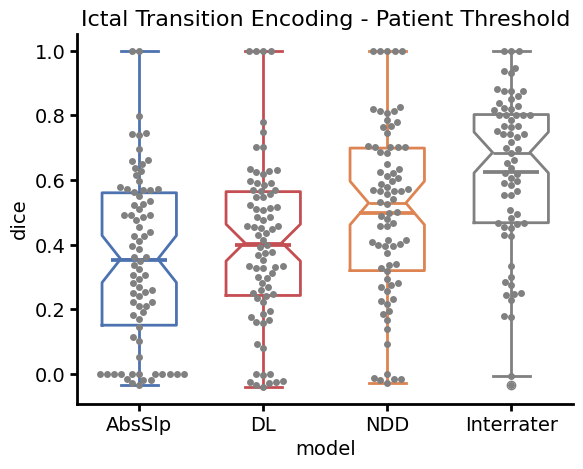

In [56]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'])
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=40,errorbar=None)
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.despine()
plt.title("Ictal Transition Encoding - Patient Threshold")
plt.savefig(ospj(figpath,'patient_tuned_onset_detection.pdf'))

In [57]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        _,p = sc.stats.ttest_ind(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(p)
_,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == 'NDD'].dice,consensus_annots.f1)
print(p)
multipletests(all_ps[:2])

AbsSlp NDD
0.0006841261440944826
DL NDD
0.018212842126861983
NDD Interrater
nan
nan


(array([ True,  True]),
 array([0.00136778, 0.01821284]),
 0.025320565519103666,
 0.025)

#### Stim vs. Spont

In [58]:
print(cohens_d(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice))
sc.stats.mannwhitneyu(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice)

0.2436178770113061


MannwhitneyuResult(statistic=872.0, pvalue=0.2132723763349187)

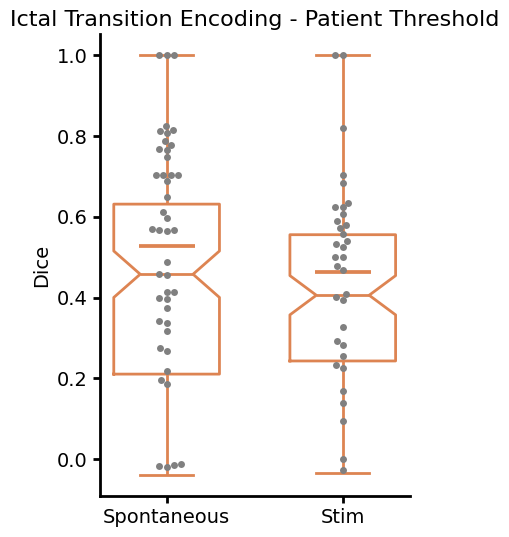

In [59]:
plt.figure(figsize=(4,6))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1,1]]
stim_plot_agreements = all_plot_agreements[all_plot_agreements.model == 'NDD']
sns.swarmplot(stim_plot_agreements,x='stim',y='dice',color='gray',native_scale=True)
sns.pointplot(stim_plot_agreements,x='stim',y='dice',palette=colors,
            marker='_',markersize=40,errorbar=None,native_scale=True)
sns.boxplot(all_plot_agreements,x='stim',y='dice',palette=colors,width=.6,notch=True,fill=False,native_scale=True)
sns.despine()
plt.xticks([0,1],['Spontaneous','Stim'])
plt.title("Ictal Transition Encoding - Patient Threshold")
plt.xlabel('')
plt.ylabel('Dice')
plt.savefig(ospj(figpath,'stim_vs_spont_detection.pdf'))

#### Spread

In [60]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']

In [61]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=nan, pvalue=nan)
WVNT
MannwhitneyuResult(statistic=nan, pvalue=nan)
LSTM
MannwhitneyuResult(statistic=nan, pvalue=nan)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

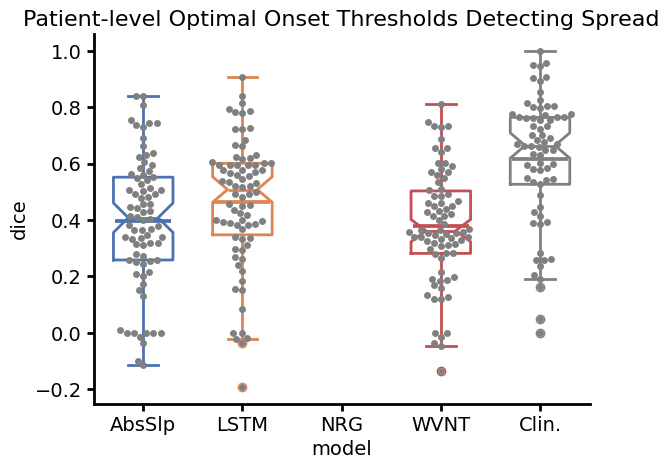

In [62]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

## KDE Model Predictions

In [321]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_opt.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_gaussianx_val_predicted_channels_nor.pkl"))
# predicted_channels = pd.read_pickle(ospj(prodatapath,"DynaSD_90centile_predicted_channels_nor.pkl"))


# predicted_channels = 
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0)]# & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)
predicted_channels['patient'] = predicted_channels.pop('Patient')

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['patient','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wdice = pred_channels_wannots.apply(apply_mcc,axis=1)
# pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [322]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_loose_dice > 0]
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_chs_strict.apply(lambda x: len(x) > 0)]

In [323]:
print(len(pred_channels_wdice.patient.unique()),len(pred_channels_wdice.approximate_onset.unique()))

21 44


In [327]:
pred_type = 'ueo_chs_strict_consensus_MCC'
# pred_type = 'ueo_consensus_strict_dice'
pred_channels_wdice['dice'] = pred_channels_wdice[pred_type]
# consensus_annots['dice'] = consensus_annots['MCC']

In [328]:
pred_channels_wdice = pd.concat([pred_channels_wdice,consensus_annots[consensus_annots.stim == 0],external_annots]).reset_index(drop=True)
pred_channels_wdice.loc[pred_channels_wdice.model == 'LSTM','model'] = 'NDD'
pred_channels_wdice

,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,...,sec_chs_loose_consensus_MCC,sec_chs_loose_any_MCC,dice,Seizure_ID,clinician,ueo,ueo_time,sec,offset,f1
0,CHOP041,NDD,0.0,416768.1800,416768.1800,2.118799,"[LP08, LE07, LJ08, LJ09, LJ10, LE08, LS05, LB01]","[LB01, LB02, LE07, LE08, LE09, LJ08, LJ09, LJ1...","[LF04, LH05]","[LF04, LF05, LH05, LH06]",...,0.190184,0.190184,-0.047499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHOP049,NDD,0.0,114973.4900,114973.4900,1.407531,"[LF01, LM01, LC07, LC06, LC05, LC04, LC03, LM0...","[LA07, LA08, LC01, LC02, LC03, LC04, LC05, LC0...",[],[],...,0.000000,0.000000,0.301124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HUP224_phaseII,NDD,0.0,339143.6435,339143.6435,2.181250,"[RB01, RA05, RA01, RB03, LB01, LB02, LB03, LB0...","[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LB0...","[RF01, LI03, RA07]","[LI03, LI04, RA07, RA08, RF01, RF02]",...,-0.038398,0.062465,0.598547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HUP224_phaseII,NDD,0.0,491467.8046,491467.8046,1.961788,"[LA01, RC04, RC03, RC02, RC01, RB03, RB02, RB0...","[LA01, LA02, LA04, LA05, LB01, LB02, LB03, LB0...","[RA08, LA09]","[LA09, LA10, RA08, RA09]",...,-0.031213,-0.036377,0.516315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HUP224_phaseII,NDD,0.0,519177.9500,519177.9500,2.304983,"[RC01, RB03, RB02, RA05, RA01]","[RA01, RA02, RA05, RA06, RB02, RB03, RB04, RC0...","[LA06, RF02, RQ01, RF01, LI02, LC04]","[LA06, LA07, LC04, LC05, LI02, LI03, RF01, RF0...",...,0.039038,0.170308,0.536745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,NaN,Ext. Clin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.2222222222222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,NaN,Ext. Clin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.2222222222222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,NaN,Ext. Clin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.3111111111111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,NaN,Ext. Clin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.43333333333333335,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.3986264594891093
0.4898482362592289
0.25   -0.006563
0.75    0.637218
Name: dice, dtype: object
2.118798769689065
0.25    1.510299
0.75    2.464038
Name: threshold, dtype: float64


MannwhitneyuResult(statistic=461.0, pvalue=0.0004962800202566736)

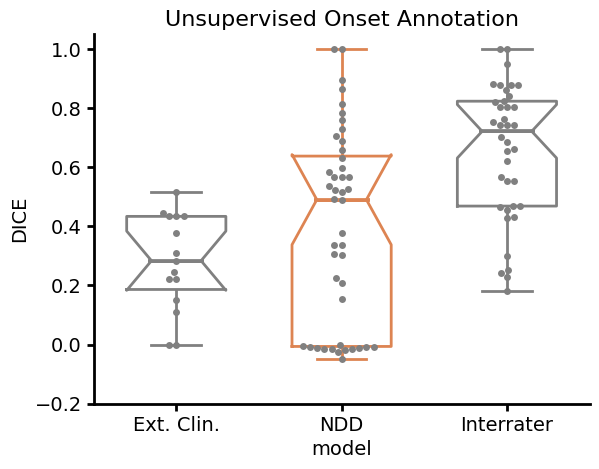

In [333]:
colors = np.array(sns.color_palette("deep", 4))[1]
kde_colors = np.vstack([[.5,.5,.5],np.array(colors),[.5,.5,.5]])
sns.boxplot(pred_channels_wdice,x='model',y="dice",palette=kde_colors,order=['Ext. Clin.','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y="dice",color='gray',order=['Ext. Clin.','NDD','Interrater'])
sns.pointplot(pred_channels_wdice,x='model',y="dice",palette=kde_colors,order = ['Ext. Clin.','NDD','Interrater'],marker='_',markersize=40,errorbar=None,estimator='median')
sns.despine()
plt.ylabel('DICE')
plt.ylim([-.2,1.05])
plt.title("Unsupervised Onset Annotation")
print(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].dice.mean())
print(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].dice.median())
print(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].dice.quantile([.25,.75]))
print(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].threshold.median())
print(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].threshold.quantile([.25,.75]))

# # bx.invert_yaxis()
sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == 'NDD'].dice.to_numpy(dtype=float),
                      pred_channels_wdice[pred_channels_wdice.model == 'Interrater'].dice.dropna().to_numpy(dtype=float))

In [28]:
# plt.figure()
# pt_pred_channels_wdice = pred_channels_wdice.groupby(['patient','model'])[[pred_type]].mean().reset_index()
# sns.boxplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False,whis=100)
# sns.swarmplot(pt_pred_channels_wdice,x='model',y=pred_type,color='gray')
# sns.pointplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
# sns.despine()
# plt.ylim([-.2,1.05])
# plt.title("KDE Unsupervised Annotation")

In [29]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        print(np.mean(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type]),np.mean(pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type]))
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        print(d)
        all_ps.append(p)
        print(p)

NDD NDD
0.40648738688277014 0.40648738688277014
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NDD Clin.
0.40648738688277014 nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
NDD Ext. Clin.
0.40648738688277014 nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Clin. NDD
nan 0.40648738688277014
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Clin. Clin.
nan nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Clin. Ext. Clin.
nan nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Ext. Clin. NDD
nan 0.40648738688277014
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Ext. Clin. Clin.
nan nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)
Ext. Clin. Ext. Clin.
nan nan
nan
MannwhitneyuResult(statistic=nan, pvalue=nan)


## Alternate Annotations

In [ ]:
# sc.stats.mannwhitneyu(all_dice,all_plot_agreements[all_plot_agreements.model == 'LSTM'].dice),
print(sc.stats.mannwhitneyu(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))

MannwhitneyuResult(statistic=311.0, pvalue=0.7471554141942756) -0.13825908084730196


In [ ]:
print(sc.stats.mannwhitneyu(consensus_annots[consensus_annots.stim == 0].dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(consensus_annots[consensus_annots.stim == 0].dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))

MannwhitneyuResult(statistic=1432.0, pvalue=3.0489242716367197e-08) 1.5625760702139988


In [ ]:
sc.stats.mannwhitneyu(consensus_annots.dice,all_dice)

MannwhitneyuResult(statistic=903.0, pvalue=6.898005099445701e-06)

In [ ]:
consensus_annots.dice.mean()

0.6253192346282613

## Onset Localization

In [73]:
ndd_vals = pd.read_pickle(ospj(prodatapath,"NDD_soz_localizations.pkl"))


In [74]:
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)

In [75]:
ndd_vals.sort_values('approximate_onset',inplace=True)
consensus_annots.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
ndd_vals_wannots = pd.merge_asof(ndd_vals,
                                    consensus_annots[['approximate_onset','patient','ueo_chs','sec_chs','ueo_consensus','sec_consensus']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')

In [76]:
def ch_soz(row):
    chs = row.channel.split('-')
    soz = row.ueo_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False
def ch_ssz(row):
    chs = row.channel.split('-')
    soz = row.sec_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False

In [77]:
ndd_vals_wannots['soz'] = ndd_vals_wannots.apply(ch_soz,axis=1)
ndd_vals_wannots['ssz'] = ndd_vals_wannots.apply(ch_ssz,axis=1)

In [78]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','soz'])[['onset_ndd','spread_ndd']].mean().reset_index()

787.0 1.2499684746454533e-09
0.9692118226600985
4.4457665397446195 5.526543599765452
1.1725045918493704 0.43106908353054685
1.6035736753799172


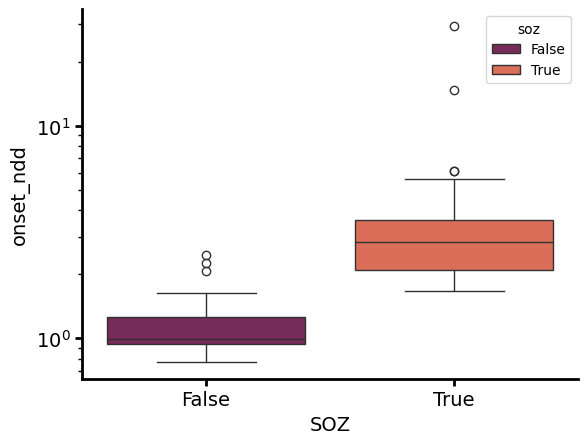

In [245]:
sns.boxplot(data=plt_ndd_vals,x='soz',y='onset_ndd',hue='soz',palette='rocket')
sns.despine()
plt.xlabel('SOZ')
plt.yscale('log')
mask1 = (plt_ndd_vals['soz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])

u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].onset_ndd,plt_ndd_vals[~mask1].onset_ndd)
print(u,p)
print(u/(n1*n2))
print(plt_ndd_vals[mask1].onset_ndd.mean(), plt_ndd_vals[mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean(), plt_ndd_vals[~mask1].onset_ndd.std())
print(plt_ndd_vals[~mask1].onset_ndd.mean() + plt_ndd_vals[~mask1].onset_ndd.std())

In [107]:
plt_ndd_vals = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM'].groupby(['patient','ssz'])[['onset_ndd','spread_ndd']].mean().reset_index()

5.0211178410786665
1.2830617017481813
738.0 1.3993735061831768e-08
0.9425287356321839


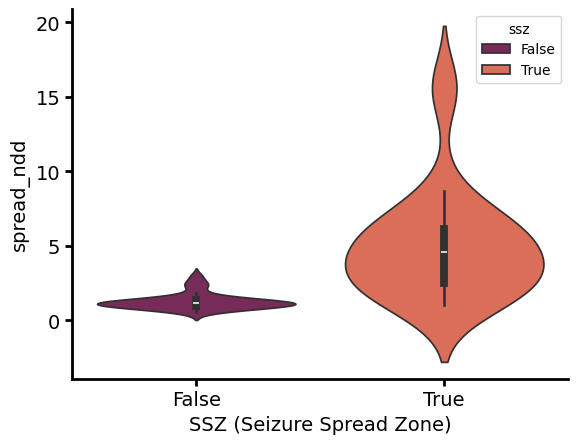

In [108]:
sns.violinplot(data=plt_ndd_vals,x='ssz',y='spread_ndd',hue='ssz',palette='rocket')
sns.despine()
plt.xlabel('SSZ (Seizure Spread Zone)')
mask1 = (plt_ndd_vals['ssz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])
u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].spread_ndd,plt_ndd_vals[~mask1].spread_ndd);
print(plt_ndd_vals[mask1].spread_ndd.mean())
print(plt_ndd_vals[~mask1].spread_ndd.mean())
print(u,p)
print(u/(n1*n2))

## MCC evaluation

In [109]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))
consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)!=2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    if len(annots) < 2:
        continue
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += matthews_corrcoef(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'MCC'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)

In [112]:
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.model == 'LSTM']
ndd_vals_wannots = ndd_vals_wannots[ndd_vals_wannots.stim == 0]

CHOP024 175520.91
CHOP044 29018.38
HUP225 393496.2
HUP225 408576.508
0.5291608886960284 0.6543212352746101


MannwhitneyuResult(statistic=1032.0, pvalue=0.024464962534658352)

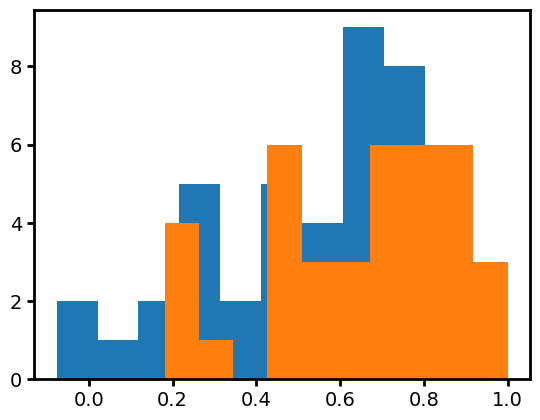

In [ ]:
all_mccs = []
dict_list = []
for _,group in ndd_vals_wannots.groupby(['patient','approximate_onset','model']):
    # sns.lineplot(group,x='channel',y='soz')
    # sns.lineplot(group,x='channel',y='onset_ndd')
    r = group[['soz','onset_ndd']].corr().iloc[1,0]
    if np.isnan(r):
        print(group.patient.iloc[0],group.approximate_onset.iloc[0])
        continue
    dict_list.append({
        'patient': group.patient.iloc[0],
        'approximate_onset': group.approximate_onset.iloc[0]
        
    })
    all_mccs.append(r)
plt.hist(all_mccs)
plt.hist(consensus_annots['MCC'])
print(np.nanmean(all_mccs),np.nanmean(consensus_annots['MCC']))
sc.stats.mannwhitneyu(consensus_annots['MCC'][~consensus_annots.MCC.isna()],np.array(all_mccs)[~np.isnan(all_mccs)])

## Region Agreement

In [ ]:
predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

In [ ]:
# Go through the already created combined dataframe.
annotations_df = consensus_annots.copy()
annotations_df['Patient'] = annotations_df['patient']
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = electrode_regions[electrode_regions.name.isin(chs)]['label'].unique()
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
annotations_df.sort_values('approximate_onset',inplace=True)

no regions for CHOP010
no regions for CHOP015
no regions for CHOP038
no regions for CHOP046


In [ ]:
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    try:
        electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    except:
        print(f'no regions for {pt}')
        continue
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique()
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals
predicted_channels.sort_values('approximate_onset',inplace=True)
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_regions_wannots.dropna(axis=0,subset='ueo_consensus_rs',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)
# pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

In [ ]:
pred_regions_wannots.to_pickle(ospj(prodatapath,'pred_regions_wannots.pkl'))

In [ ]:
pred_regions_wannots

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
27,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,1.126867,"[LA01, RA01, RA02, RA03, RA04, RA05, RX01, RX0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[RQ01, LB07, LA09, LQ03]",...,1.0,[],[],[],[ left middle temporal ],"[ left middle temporal , EmptyLabel, left sup...",[],[],[],[]
41,HUP224,HUP224_phaseII,LSTM,0.0,491467.8046,491467.8046,1.098283,"[LA01, LX02, RA01, RA03, RA04, RA05, RA06, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[RP03, RW08]",...,1.0,[],[],[],[],"[ left middle temporal , EmptyLabel, left sup...",[],[],[],[]
43,HUP224,HUP224_phaseII,LSTM,0.0,519177.9500,519177.9500,1.228444,"[RB01, RF05, RC03, RC02, RC01, RB03, RB02, RA0...","[LB05, LB06, RA01, RA02, RA03, RA04, RA05, RA0...","[LI03, RC06]",...,1.0,[],[],[],[],"[ left middle temporal , EmptyLabel, left sup...",[],[],[],[]
26,HUP225,HUP225_phaseII,LSTM,0.0,304944.5422,304944.5422,1.573950,[RB01],"[RB01, RB02]",[],...,1.0,[],[],[],[],"[EmptyLabel, right middle temporal , right s...",[],[],[],[]
30,HUP225,HUP225_phaseII,LSTM,0.0,393496.2000,393496.2000,1.155295,"[RPc06, RPc04, RZ08]","[RPc04, RPc05, RPc06, RPc07, RZ08, RZ09]","[RT04, RZ07]",...,1.0,[],[],[],[],"[EmptyLabel, right middle temporal , right s...",[],[],[],[]
44,HUP229,HUP229_phaseII,LSTM,0.0,541697.9824,541697.9824,1.654549,"[LC02, LA02, LG03, LP09, LG01, LG02, LP10, LA01]","[LA01, LA02, LA03, LC02, LC03, LG01, LG02, LG0...",[],...,1.0,[ left inferior parietal ],[ left inferior parietal ],[],[],"[EmptyLabel, left middle temporal , left inf...",[],[],[],[]
15,HUP230,HUP230_phaseII,LSTM,0.0,251120.6600,251120.6600,0.884972,"[LC01, LC02, LC06, LF06, LL07, LL09, LM05]","[LC01, LC02, LC03, LC06, LC07, LF06, LF07, LL0...",[],...,1.0,[],[ left postcentral ],[],[],"[EmptyLabel, left middle temporal , left pos...",[],[],[],[]
23,HUP230,HUP230_phaseII,LSTM,0.0,296207.3400,296207.3400,1.418035,"[LC02, LC01, LB01]","[LB01, LB02, LC01, LC02, LC03]",[],...,1.0,[],[],[],[],"[EmptyLabel, left middle temporal , left pos...",[],[],[],[]
28,HUP230,HUP230_phaseII,LSTM,0.0,371985.4515,371985.4515,1.259502,"[LB01, LC02, LC01, LB02]","[LB01, LB02, LB03, LC01, LC02, LC03]",[LA02],...,1.0,[],[],[],[],"[EmptyLabel, left middle temporal , left pos...",[],[],[],[]
5,HUP235,HUP235_phaseII,LSTM,0.0,107374.2078,107374.2078,1.042950,"[LC03, LC02, LC01, LS02, LB03, LB02, LB04, LZ0...","[LB01, LB02, LB03, LB04, LB05, LC01, LC02, LC0...",[],...,1.0,[],[],[],[],"[ left middle temporal , EmptyLabel, left sup...",[],[],[],[]


In [ ]:
pred_regions_wannots.apply(apply_region_dice,axis=1)

KeyError: 'ueo_consensus'

In [ ]:
def apply_region_dice(row):
    all_rs = row.all_rs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row